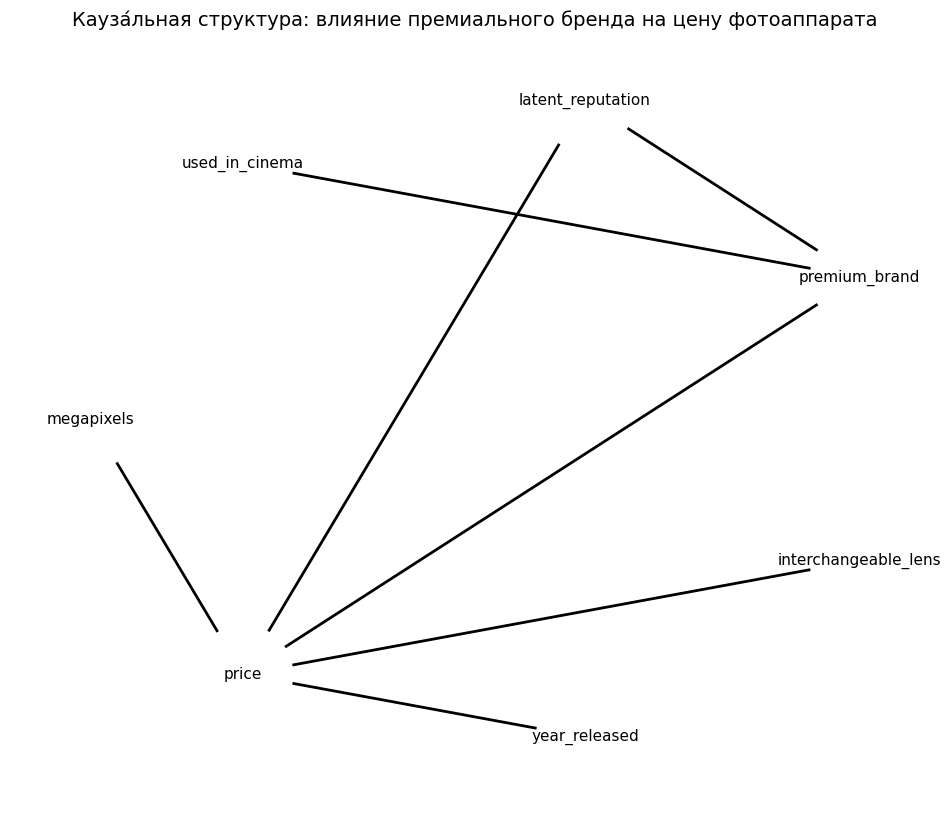

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Задаем параметры визуализации
pl_params = {
    'node_color': 'white',
    'node_size': 5000,
    'width': 2,
    'arrowstyle': '->',
    'arrowsize': 22,
    'font_size': 11
}

# Граф: влияние премиального бренда на цену
edges = [
    ('megapixels', 'price'),
    ('year_released', 'price'),
    ('interchangeable_lens', 'price'),
    ('premium_brand', 'price'),
    ('latent_reputation', 'price'),
    ('latent_reputation', 'premium_brand'),
    ('used_in_cinema', 'premium_brand'),
]

# Построение графа
G = nx.DiGraph(directed=True)
G.add_edges_from(edges)

pos = nx.shell_layout(G)
plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_color=pl_params['node_color'], node_size=pl_params['node_size'])
nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle=pl_params['arrowstyle'], width=pl_params['width'], arrowsize=pl_params['arrowsize'])
nx.draw_networkx_labels(G, pos, font_size=pl_params['font_size'])
plt.title("Кауза́льная структура: влияние премиального бренда на цену фотоаппарата", fontsize=14)
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm, t, expon

class CameraMarketSimulator:
    def __init__(self, seed=42, n=1200):
        self.seed = seed
        self.n = n
        np.random.seed(self.seed)

    def generate_data(self):
        n = self.n

        # Контрольные переменные
        megapixels = np.clip(np.random.normal(24, 5, n), 10, 50)
        year_released = np.random.randint(2015, 2025, n)
        interchangeable_lens = np.random.binomial(1, 0.6, n)

        # Ненаблюдаемая переменная (латентная репутация)
        latent_reputation = np.clip(np.random.normal(0, 1, n), -3, 3)

        # Инструментальная переменная
        used_in_cinema = np.random.binomial(1, 0.5, n)

        # Вероятность премиальности — смещение понижено для ограничения доли
        prob_premium = norm.cdf(
            -0.5 + 0.8 * used_in_cinema +
            0.6 * interchangeable_lens +
            0.4 * np.log(megapixels) +
            1.0 * latent_reputation
        )
        premium_brand = np.random.binomial(1, prob_premium)

        # Генерация цены
        price_0 = (
            50000 +
            10000 * interchangeable_lens +
            1200 * np.sqrt(megapixels) +
            700 * (year_released - 2015) +
            6000 * latent_reputation
        )

        price_1 = (
            60000 +
            12000 * interchangeable_lens +
            1500 * np.sqrt(megapixels) +
            800 * (year_released - 2015) +
            7000 * latent_reputation +
            10000
        )

        epsilon_0 = 5000 * t(df=10).rvs(n)
        epsilon_1 = 4000 * expon(scale=1).rvs(n)

        price = price_1 * premium_brand + price_0 * (1 - premium_brand) + epsilon_0 * (1 - premium_brand) + epsilon_1 * premium_brand

        df = pd.DataFrame({
            'megapixels': megapixels,
            'year_released': year_released,
            'interchangeable_lens': interchangeable_lens,
            'used_in_cinema': used_in_cinema,
            'premium_brand': premium_brand,
            'price': price
        })

        return df

# Генерация данных
simulator = CameraMarketSimulator()
df = simulator.generate_data()

# Описательные статистики
desc_cont = df[["megapixels", "year_released", "price"]].describe().T
desc_cont["median"] = df[["megapixels", "year_released", "price"]].median()

desc_bin = df[["interchangeable_lens", "used_in_cinema", "premium_brand"]].agg(["mean", "sum"]).T
desc_bin.columns = ["proportion", "count"]

corr_matrix = df.corr(numeric_only=True)

desc_combined = pd.concat([desc_cont, desc_bin], axis=0)
desc_combined, corr_matrix



(                       count          mean           std           min  \
 megapixels            1200.0     24.194353      4.934517     10.000000   
 year_released         1200.0   2019.438333      2.816524   2015.000000   
 price                 1200.0  87902.532937  16382.768196  28601.860855   
 interchangeable_lens   716.0           NaN           NaN           NaN   
 used_in_cinema         588.0           NaN           NaN           NaN   
 premium_brand         1011.0           NaN           NaN           NaN   
 
                                25%           50%          75%            max  \
 megapixels               20.874977     24.241516     27.38007      43.263657   
 year_released          2017.000000   2019.000000   2022.00000    2024.000000   
 price                 81678.222622  91277.127035  98508.41666  125921.084116   
 interchangeable_lens           NaN           NaN          NaN            NaN   
 used_in_cinema                 NaN           NaN          NaN      

In [ ]:
from sklearn.model_selection import train_test_split

# Целевая переменная и признаки
X = df.drop(columns=['price'])
y = df['price']

# Разделение на обучающую и тестовую выборки (25% в тесте)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape[0], X_test.shape[0]


(900, 300)

In [ ]:
# Итоговый код: классификация premium_brand с KNN, Logistic Regression и Random Forest

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Предполагается, что DataFrame `df` уже загружен и содержит нужные переменные

# 1. Определение признаков и целевой переменной
y_class = df["premium_brand"]
X_class = df[["used_in_cinema", "interchangeable_lens", "megapixels"]]

# 2. Деление на обучающую и тестовую выборки
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_class, y_class, test_size=0.25, random_state=42)

# 3. Инициализация моделей
knn = KNeighborsClassifier(n_neighbors=5)
logreg = LogisticRegression()
rf = RandomForestClassifier(n_estimators=100, random_state=322)

# 4. Обучение моделей
knn.fit(X_train_clf, y_train_clf)
logreg.fit(X_train_clf, y_train_clf)
rf.fit(X_train_clf, y_train_clf)

# 5. Предсказания на тестовой выборке
y_pred_knn = knn.predict(X_test_clf)
y_pred_logreg = logreg.predict(X_test_clf)
y_pred_rf = rf.predict(X_test_clf)

# 6. Оценка точности
results = {
    'Model': ['KNN', 'Logistic Regression', 'Random Forest'],
    'Train Accuracy': [
        accuracy_score(y_train_clf, knn.predict(X_train_clf)),
        accuracy_score(y_train_clf, logreg.predict(X_train_clf)),
        accuracy_score(y_train_clf, rf.predict(X_train_clf))
    ],
    'Test Accuracy': [
        accuracy_score(y_test_clf, y_pred_knn),
        accuracy_score(y_test_clf, y_pred_logreg),
        accuracy_score(y_test_clf, y_pred_rf)
    ],
    'Validation Accuracy': [
        cross_val_score(knn, X_train_clf, y_train_clf, scoring='accuracy', cv=5).mean(),
        cross_val_score(logreg, X_train_clf, y_train_clf, scoring='accuracy', cv=5).mean(),
        cross_val_score(rf, X_train_clf, y_train_clf, scoring='accuracy', cv=5).mean()
    ]
}

# 7. Формирование таблицы результатов
results_df = pd.DataFrame(results)
results_df


,Model,Train Accuracy,Test Accuracy,Validation Accuracy
0,KNN,0.857778,0.773333,0.818889
1,Logistic Regression,0.846667,0.830000,0.846667
2,Random Forest,0.998889,0.760000,0.751111


In [ ]:
from sklearn.model_selection import GridSearchCV

# Словари с параметрами
param_grid_knn = {'n_neighbors': [3, 5, 7, 9]}
param_grid_logreg = {'C': [0.01, 0.1, 1, 10, 100]}
param_grid_rf_cv = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5]
}

# GridSearchCV для каждого
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_logreg = GridSearchCV(LogisticRegression(), param_grid_logreg, cv=5, scoring='accuracy')
grid_rf_cv = GridSearchCV(RandomForestClassifier(random_state=322), param_grid_rf_cv, cv=5, scoring='accuracy')

# Обучение
grid_knn.fit(X_train_clf, y_train_clf)
grid_logreg.fit(X_train_clf, y_train_clf)
grid_rf_cv.fit(X_train_clf, y_train_clf)

# Предсказания
best_knn = grid_knn.best_estimator_
best_logreg = grid_logreg.best_estimator_
best_rf_cv = grid_rf_cv.best_estimator_

y_test_knn_opt = best_knn.predict(X_test_clf)
y_test_logreg_opt = best_logreg.predict(X_test_clf)
y_test_rf_cv_opt = best_rf_cv.predict(X_test_clf)

# Сравнение исходных и оптимизированных
tuning_results = {
    'Model': ['KNN', 'Logistic Regression', 'Random Forest (CV)'],
    'Initial Params': [
        'n_neighbors=5',
        'C=1.0',
        'n_estimators=100, max_depth=None, min_samples_split=2'
    ],
    'Tuned Params': [
        str(grid_knn.best_params_),
        str(grid_logreg.best_params_),
        str(grid_rf_cv.best_params_)
    ],
    'CV Accuracy (Initial)': [
        cross_val_score(KNeighborsClassifier(n_neighbors=5), X_train_clf, y_train_clf, cv=5).mean(),
        cross_val_score(LogisticRegression(), X_train_clf, y_train_clf, cv=5).mean(),
        cross_val_score(RandomForestClassifier(random_state=322), X_train_clf, y_train_clf, cv=5).mean()
    ],
    'CV Accuracy (Tuned)': [
        grid_knn.best_score_,
        grid_logreg.best_score_,
        grid_rf_cv.best_score_
    ],
    'Test Accuracy (Initial)': [
        accuracy_score(y_test_clf, knn.predict(X_test_clf)),
        accuracy_score(y_test_clf, logreg.predict(X_test_clf)),
        accuracy_score(y_test_clf, rf.predict(X_test_clf))
    ],
    'Test Accuracy (Tuned)': [
        accuracy_score(y_test_clf, y_test_knn_opt),
        accuracy_score(y_test_clf, y_test_logreg_opt),
        accuracy_score(y_test_clf, y_test_rf_cv_opt)
    ]
}

tuning_results_df = pd.DataFrame(tuning_results)
tuning_results_df


,Model,Initial Params,Tuned Params,CV Accuracy (Initial),CV Accuracy (Tuned),Test Accuracy (Initial),Test Accuracy (Tuned)
0,KNN,n_neighbors=5,{'n_neighbors': 7},0.818889,0.835556,0.773333,0.786667
1,Logistic Regression,C=1.0,{'C': 0.01},0.846667,0.846667,0.830000,0.830000
2,Random Forest (CV),"n_estimators=100, max_depth=None, min_samples_...","{'max_depth': 3, 'min_samples_split': 2, 'n_es...",0.751111,0.846667,0.760000,0.830000


In [ ]:
# Сетка параметров для Random Forest с оценкой по OOB-ошибке
param_grid_rf_oob = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5]
}

# Обучение с перебором параметров и включенной oob_score
best_oob_score = 0
best_oob_model = None
best_oob_params = {}

for n in param_grid_rf_oob['n_estimators']:
    for d in param_grid_rf_oob['max_depth']:
        for m in param_grid_rf_oob['min_samples_split']:
            model = RandomForestClassifier(
                n_estimators=n,
                max_depth=d,
                min_samples_split=m,
                oob_score=True,
                bootstrap=True,
                random_state=322
            )
            model.fit(X_train_clf, y_train_clf)
            if model.oob_score_ > best_oob_score:
                best_oob_score = model.oob_score_
                best_oob_model = model
                best_oob_params = {
                    'n_estimators': n,
                    'max_depth': d,
                    'min_samples_split': m
                }

# Оценка на тестовой выборке
test_accuracy_oob = accuracy_score(y_test_clf, best_oob_model.predict(X_test_clf))

best_oob_params, best_oob_score, test_accuracy_oob


({'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2},
 0.8466666666666667,
 0.83)

In [ ]:
from sklearn.metrics import f1_score, make_scorer

# Альтернативный критерий: F1-метрика (лучше подходит при несбалансированных классах)
# Переобучение модели Random Forest по F1
best_f1_score = 0
best_f1_model = None
best_f1_params = {}

for n in param_grid_rf_oob['n_estimators']:
    for d in param_grid_rf_oob['max_depth']:
        for m in param_grid_rf_oob['min_samples_split']:
            model = RandomForestClassifier(
                n_estimators=n,
                max_depth=d,
                min_samples_split=m,
                oob_score=False,
                bootstrap=True,
                random_state=322
            )
            model.fit(X_train_clf, y_train_clf)
            preds = model.predict(X_test_clf)
            f1 = f1_score(y_test_clf, preds)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_f1_model = model
                best_f1_params = {
                    'n_estimators': n,
                    'max_depth': d,
                    'min_samples_split': m
                }

# Оценка accuracy у лучшей F1-модели
test_accuracy_f1 = accuracy_score(y_test_clf, best_f1_model.predict(X_test_clf))

best_f1_params, best_f1_score, test_accuracy_f1


({'n_estimators': 50, 'max_depth': 3, 'min_samples_split': 2},
 0.907103825136612,
 0.83)

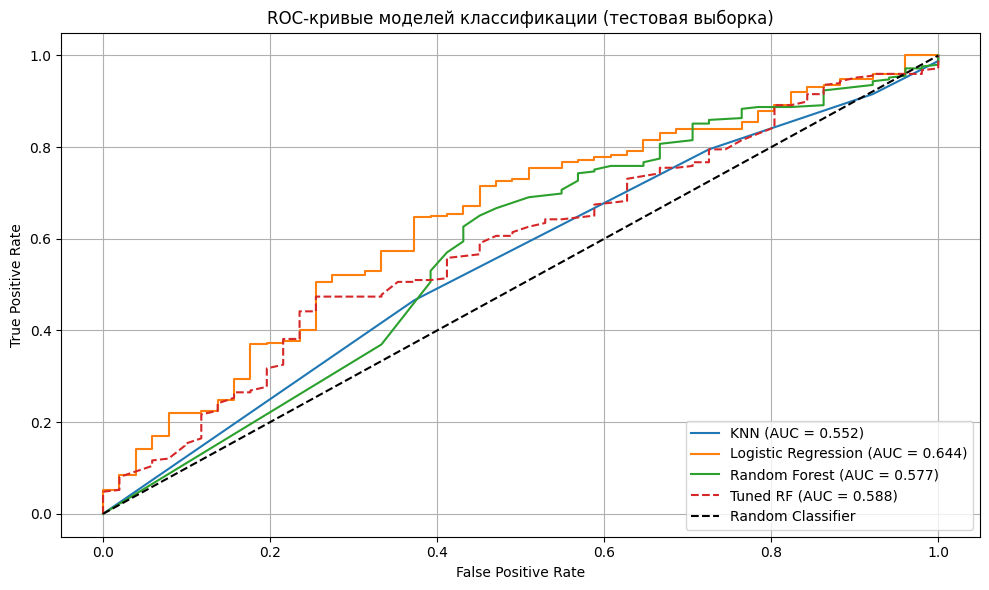

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Предсказания вероятностей
proba_knn = knn.predict_proba(X_test_clf)[:, 1]
proba_logreg = logreg.predict_proba(X_test_clf)[:, 1]
proba_rf = rf.predict_proba(X_test_clf)[:, 1]
proba_best_rf = best_f1_model.predict_proba(X_test_clf)[:, 1]

# ROC-кривые
fpr_knn, tpr_knn, _ = roc_curve(y_test_clf, proba_knn)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test_clf, proba_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test_clf, proba_rf)
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test_clf, proba_best_rf)

# AUC
auc_knn = roc_auc_score(y_test_clf, proba_knn)
auc_logreg = roc_auc_score(y_test_clf, proba_logreg)
auc_rf = roc_auc_score(y_test_clf, proba_rf)
auc_best_rf = roc_auc_score(y_test_clf, proba_best_rf)

# Построение ROC-кривой
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})')
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {auc_logreg:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_best_rf, tpr_best_rf, label=f'Tuned RF (AUC = {auc_best_rf:.3f})', linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей классификации (тестовая выборка)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Предсказания вероятностей на обучающей и тестовой выборках
proba_knn_train = knn.predict_proba(X_train_clf)[:, 1]
proba_logreg_train = logreg.predict_proba(X_train_clf)[:, 1]
proba_rf_train = rf.predict_proba(X_train_clf)[:, 1]
proba_best_rf_train = best_f1_model.predict_proba(X_train_clf)[:, 1]

proba_knn_test = knn.predict_proba(X_test_clf)[:, 1]
proba_logreg_test = logreg.predict_proba(X_test_clf)[:, 1]
proba_rf_test = rf.predict_proba(X_test_clf)[:, 1]
proba_best_rf_test = best_f1_model.predict_proba(X_test_clf)[:, 1]

# Словари с вероятностями
train_probs = {
    'KNN': proba_knn_train,
    'Logistic Regression': proba_logreg_train,
    'Random Forest': proba_rf_train,
    'Tuned RF': proba_best_rf_train
}

test_probs = {
    'KNN': proba_knn_test,
    'Logistic Regression': proba_logreg_test,
    'Random Forest': proba_rf_test,
    'Tuned RF': proba_best_rf_test
}


# Собственная нелинейная функция прибыли (усложнённый вариант)
# Пример: логарифмическая награда за TP и экспоненциальный штраф за FN
from sklearn.metrics import confusion_matrix
def custom_profit_function(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    profit = (
        1000 * np.log1p(tp) +        # логарифмическая польза от верных "премиум"
        300 * tn -                   # фиксированная польза от верных "не премиум"
        1500 * np.exp(0.2 * fn) -    # сильный штраф за упущенных премиумов
        600 * fp                     # мягкий штраф за ложные премиумы
    )
    return profit

# Поиск порога с максимальной custom-прибылью
def find_best_threshold_custom(y_true, y_proba):
    thresholds = np.linspace(0, 1, 200)
    best_profit = -np.inf
    best_threshold = 0.5
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        profit = custom_profit_function(y_true, y_pred)
        if profit > best_profit:
            best_profit = profit
            best_threshold = threshold
    return best_threshold, best_profit

# Перерасчёт с новой функцией
custom_results = []

for name in train_probs.keys():
    threshold, train_profit = find_best_threshold_custom(y_train_clf, train_probs[name])
    test_pred = (test_probs[name] >= threshold).astype(int)
    test_profit = custom_profit_function(y_test_clf, test_pred)
    auc_score = roc_auc_score(y_test_clf, test_probs[name])
    custom_results.append({
        'Model': name,
        'AUC (Test)': round(auc_score, 3),
        'Best Threshold': round(threshold, 3),
        'Custom Test Profit': int(test_profit)
    })

custom_profit_df = pd.DataFrame(custom_results)
custom_profit_df


,Model,AUC (Test),Best Threshold,Custom Test Profit
0,KNN,0.552,0.201,-27823
1,Logistic Regression,0.644,0.693,-26578
2,Random Forest,0.577,0.533,-2466615
3,Tuned RF,0.588,0.709,-27324


[bnlearn]> Auto generate placeholders for the CPTs.
[bnlearn] >CPT for premium_brand:
+----------------------+-----+-------------------------+
| used_in_cinema       | ... | used_in_cinema(1)       |
+----------------------+-----+-------------------------+
| interchangeable_lens | ... | interchangeable_lens(1) |
+----------------------+-----+-------------------------+
| megapixels           | ... | megapixels(1)           |
+----------------------+-----+-------------------------+
| premium_brand(0)     | ... | 0.5                     |
+----------------------+-----+-------------------------+
| premium_brand(1)     | ... | 0.5                     |
+----------------------+-----+-------------------------+
[bnlearn] >CPT for megapixels:
+---------------+-----+
| megapixels(0) | 0.5 |
+---------------+-----+
| megapixels(1) | 0.5 |
+---------------+-----+
[bnlearn] >CPT for used_in_cinema:
+-------------------+-----+
| used_in_cinema(0) | 0.5 |
+-------------------+-----+
| used_in_cinema(

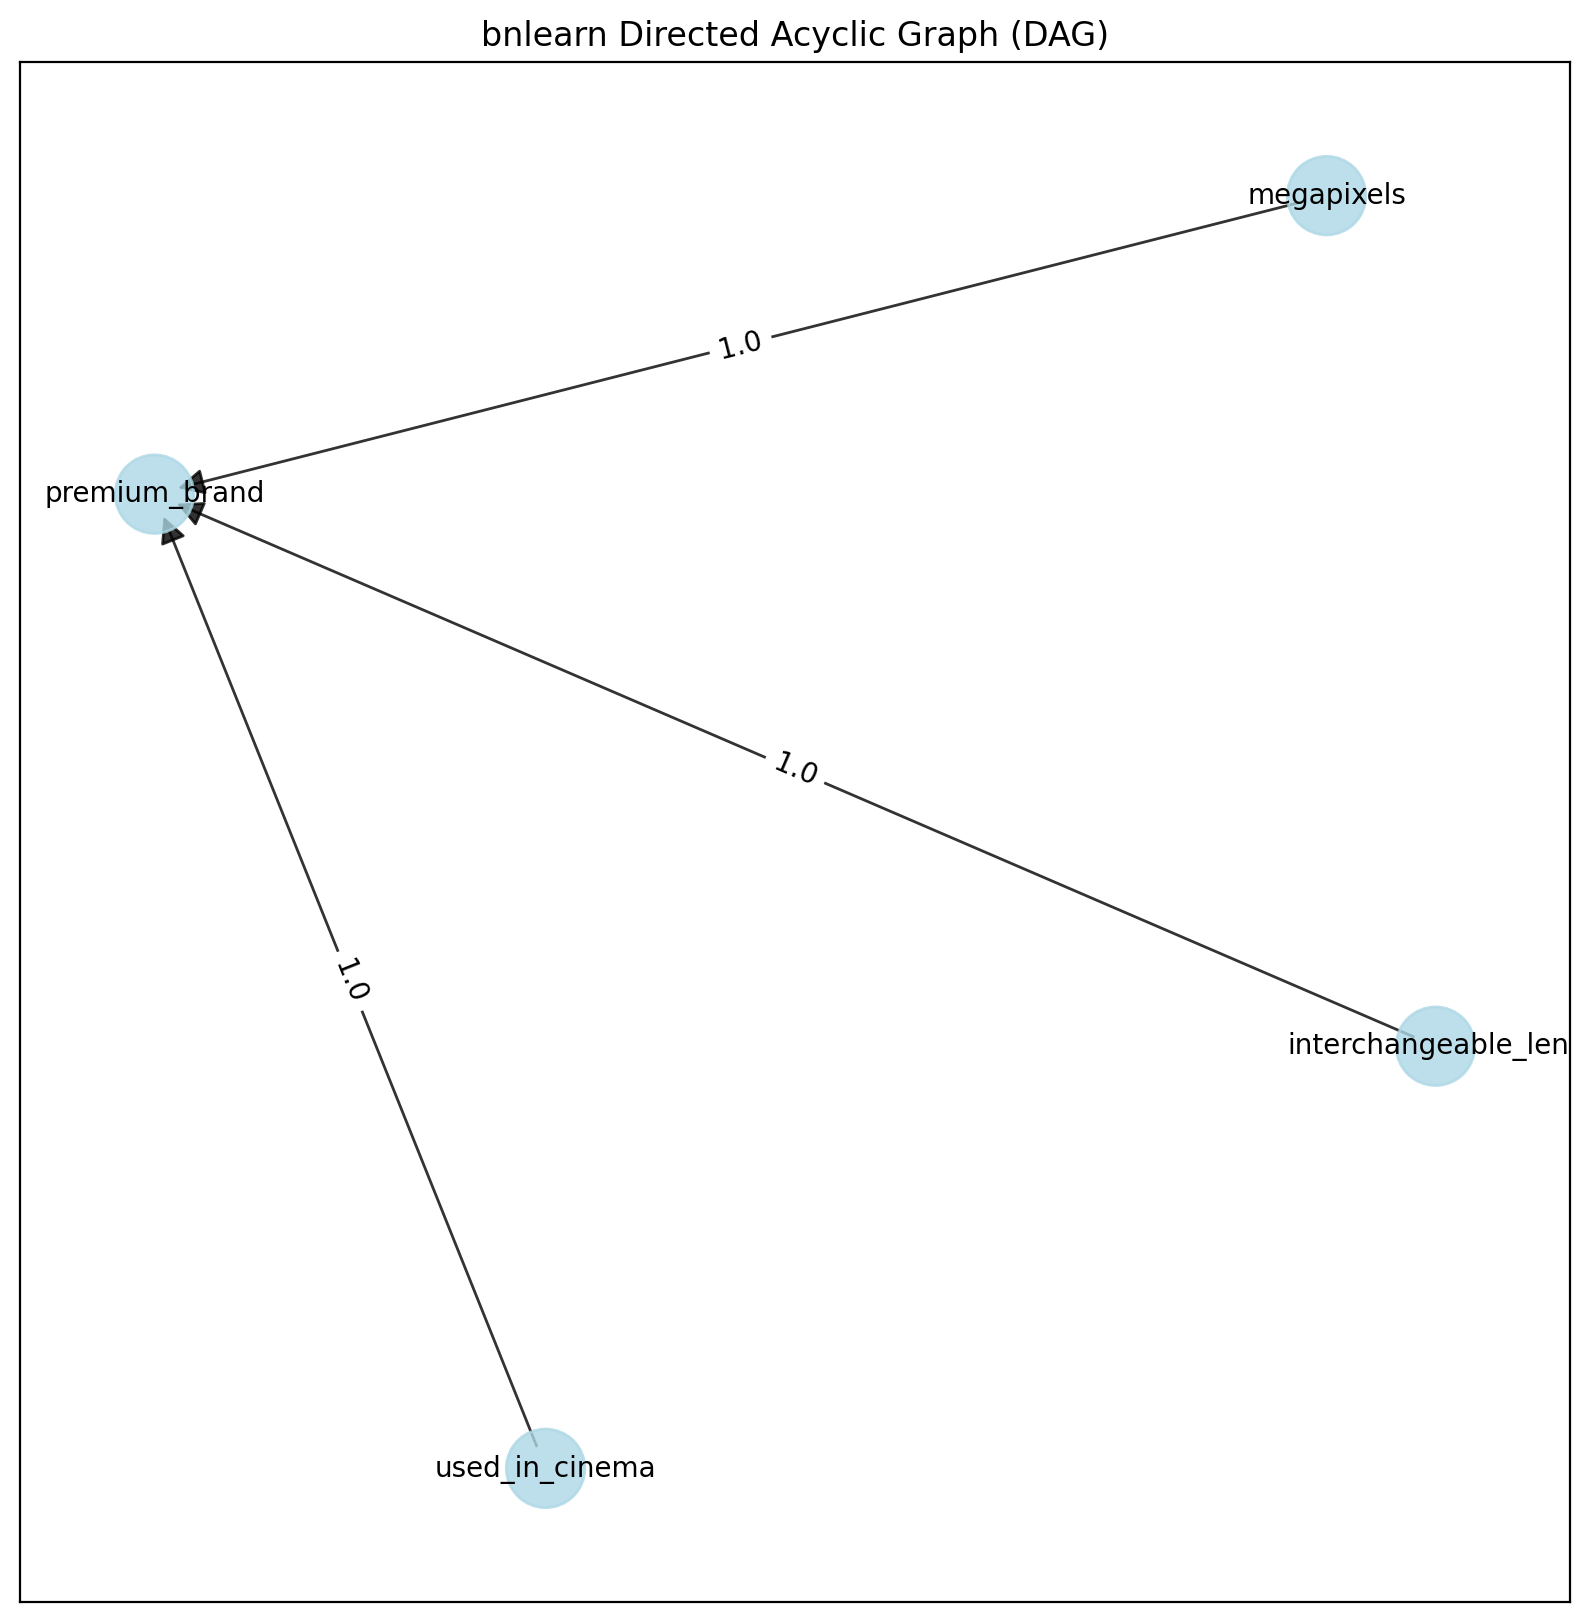

[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >CPD of premium_brand:
+----------------------+-----+-----------------------------+
| interchangeable_lens | ... | interchangeable_lens(1)     |
+----------------------+-----+-----------------------------+
| megapixels           | ... | megapixels((28.11, 37.601]) |
+----------------------+-----+-----------------------------+
| used_in_cinema       | ... | used_in_cinema(1)           |
+----------------------+-----+-----------------------------+
| premium_brand(0)     | ... | 0.08928571428571429         |
+----------------------+-----+-----------------------------+
| premium_brand(1)     | ... | 0.9107142857142857          |
+----------------------+-----+-----------------------------+
[bnlearn] >CPD of megapixels:
+------------------------------+-----+
| megapixels((9.999, 20.094])  | 0.2 |
+------------------------------+-----+
| megapixels((20.094, 22.875]) | 0.2 |
+------------------------------+-----+
| megapi

100%|██████████| 20/20 [00:00<00:00, 623.79it/s]


,premium_brand,p
0,1,0.962963
1,1,1.000000
2,1,0.736842
3,1,0.774194
4,1,0.861111


In [ ]:
# 1-я ячейка: создание ручного DAG для переменной 'premium_brand'
!pip install bnlearn
import bnlearn

# Подготовка данных
data1 = X_train_clf.copy()
data1['premium_brand'] = y_train_clf

data_test = X_test_clf.copy()
data_test['premium_brand'] = y_test_clf

# Оставим только нужные переменные
data_test = data_test[['megapixels', 'used_in_cinema', 'interchangeable_lens', 'premium_brand']]
data1 = data1[['megapixels', 'used_in_cinema', 'interchangeable_lens', 'premium_brand']]

# Дискретизация переменной megapixels
data1['megapixels'] = pd.qcut(data1['megapixels'], q=5, duplicates='drop')
megapixels_bins = data1['megapixels'].cat.categories
data_test['megapixels'] = pd.cut(data_test['megapixels'], bins=megapixels_bins)

# Удаляем возможные NaN
data1.dropna(inplace=True)
data_test.dropna(inplace=True)

# Ручной граф
edges = [
    ("used_in_cinema", "premium_brand"),
    ("interchangeable_lens", "premium_brand"),
    ("megapixels", "premium_brand")
]

# Создание DAG и обучение
DAG_manual = bnlearn.make_DAG(edges)
bnlearn.plot(DAG_manual, interactive=False)
bn_manual_trained = bnlearn.parameter_learning.fit(DAG_manual, data1, methodtype='ml')

# Предсказание на тесте
predict_bn_manual = bnlearn.predict(bn_manual_trained, variables='premium_brand', df=data_test)
predict_bn_manual.head()



In [ ]:

accuracy_score(data_test['premium_brand'], predict_bn_manual['premium_brand'])


0.8288590604026845

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >No changes made to existing bayes DAG.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


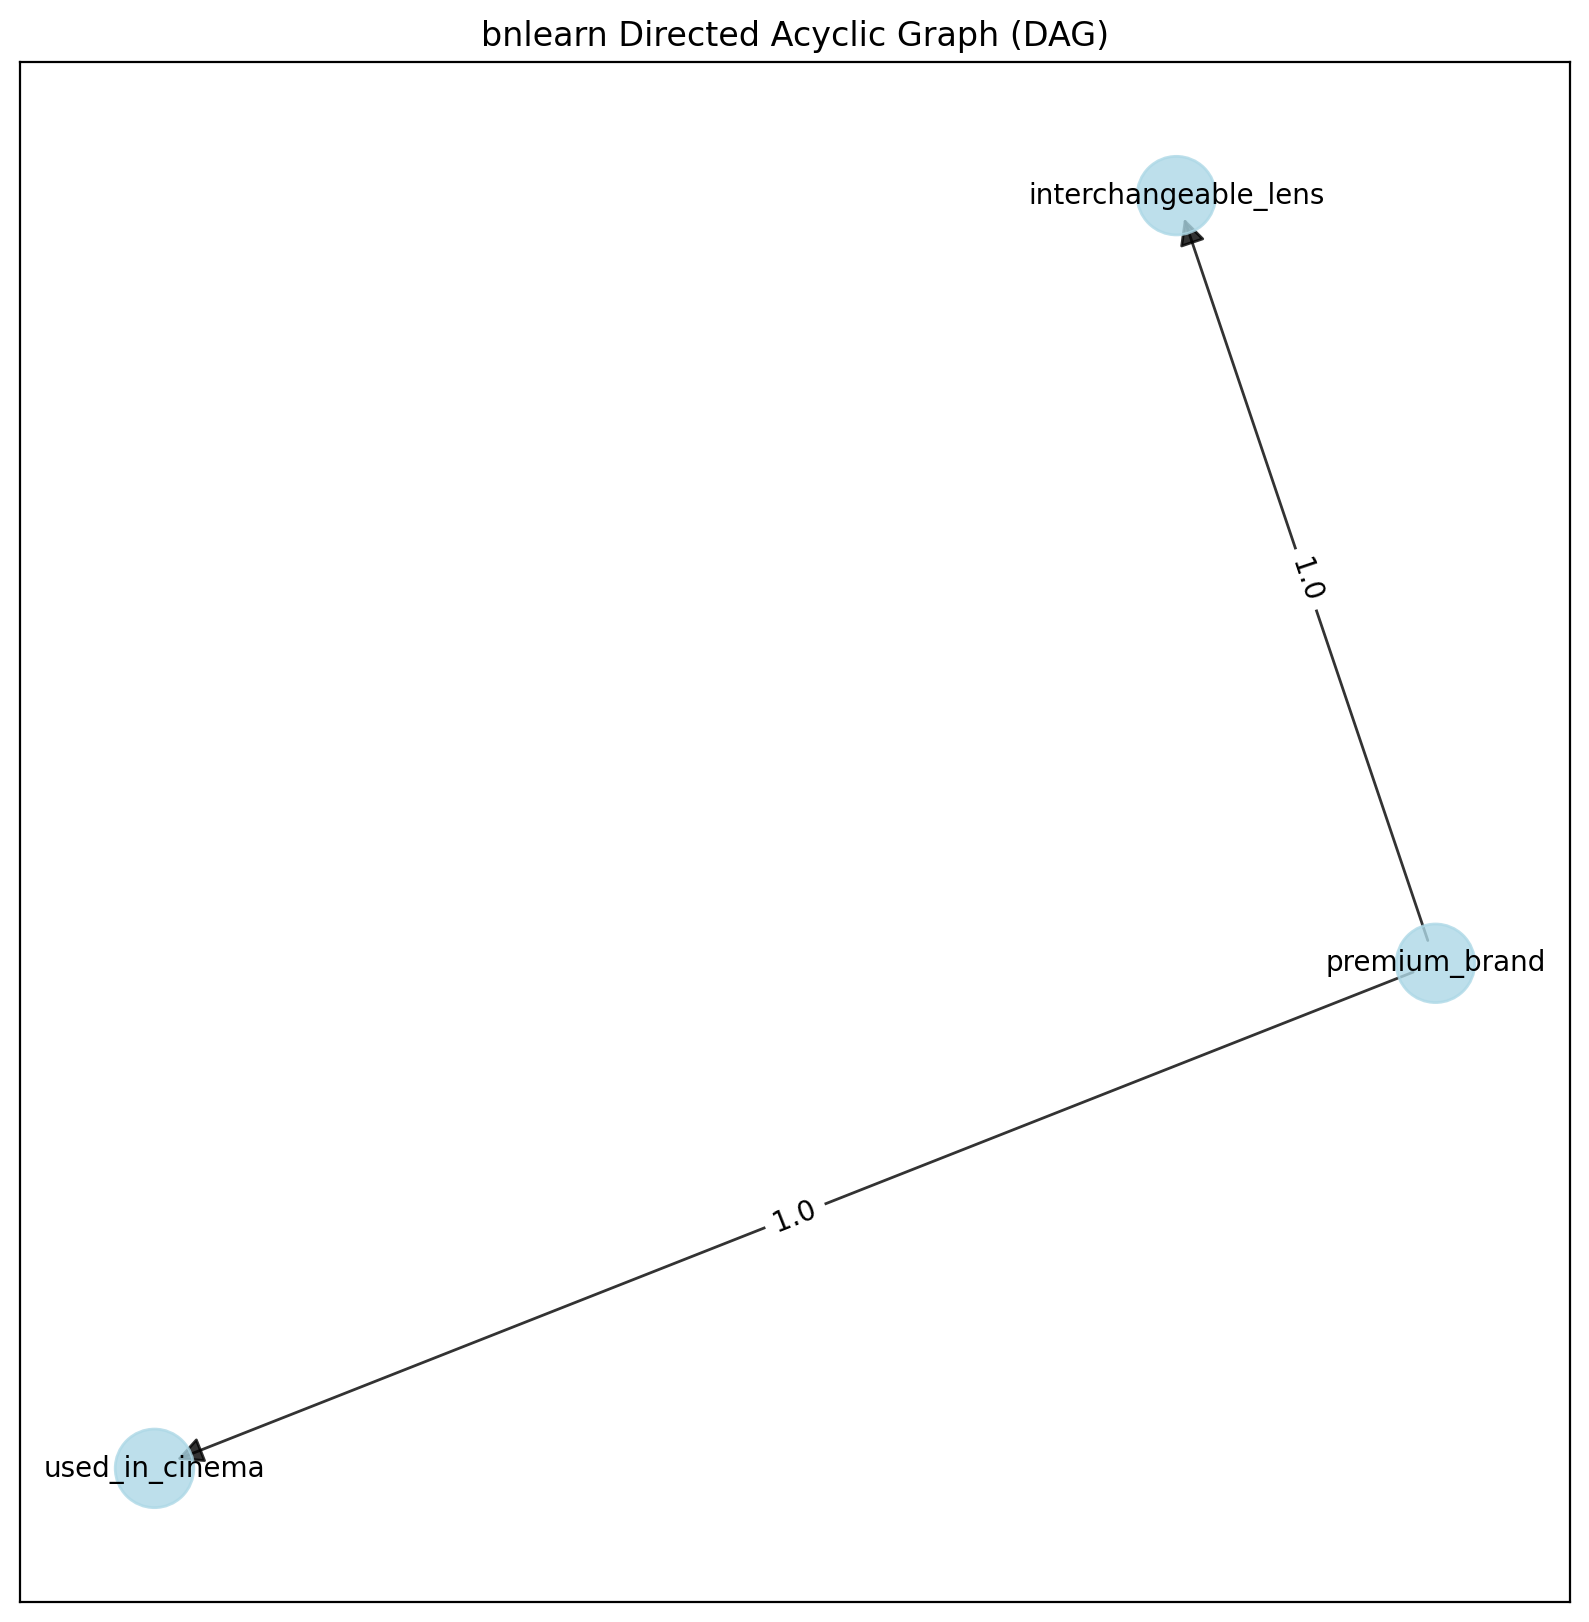

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of premium_brand:
+------------------+----------+
| premium_brand(0) | 0.335789 |
+------------------+----------+
| premium_brand(1) | 0.664211 |
+------------------+----------+
[bnlearn] >CPD of used_in_cinema:
+-------------------+---------------------+---------------------+
| premium_brand     | premium_brand(0)    | premium_brand(1)    |
+-------------------+---------------------+---------------------+
| used_in_cinema(0) | 0.5454545454545454  | 0.48415213946117275 |
+-------------------+---------------------+---------------------+
| used_in_cinema(1) | 0.45454545454545453 | 0.5158478605388273  |
+-------------------+---------------------+---------------------+
[bnlearn] >CPD of interchangeable_lens:
+-------------------------+--------------------+--------------------+
| premi

100%|██████████| 4/4 [00:00<00:00, 367.42it/s]


0.6032785583869176

In [ ]:
data_disc = X_train_clf.copy()
data_disc['premium_brand'] = y_train_clf

# Дискретизируем megapixels
data_disc['megapixels'] = pd.qcut(data_disc['megapixels'], q=5, duplicates='drop')

# Удаляем возможные пропуски
data_disc.dropna(inplace=True)
learned_structure = bnlearn.structure_learning.fit(data_disc)
DAG_learned = bnlearn.make_DAG(learned_structure)
bnlearn.plot(DAG_learned)

bn_learned_trained = bnlearn.parameter_learning.fit(DAG_learned, data_disc)
from sklearn.metrics import accuracy_score, roc_auc_score
vars_in_graph = bn_learned_trained['model'].nodes()
data_test_filtered = data_test[list(vars_in_graph)]
predict_bn_learned = bnlearn.predict(bn_learned_trained, variables='premium_brand', df=data_test_filtered)

# Accuracy и AUC
accuracy_score(data_test['premium_brand'], predict_bn_learned['premium_brand'])
roc_auc_score(data_test['premium_brand'], predict_bn_learned['p'])


